# Intro

This notebook implements an experiment aimed to verify accuracy of Deep Hybrid AutoencodeR Recommendation ENgine (DHARREN), on a dataset used in a [recent publication](https://github.com/MengtingWan/marketBias). 

# Technical prep

In [99]:
import pandas as pd
import io
import requests
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix, save_npz, load_npz
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from tqdm.autonotebook import tqdm
from tqdm import trange

In [96]:
%matplotlib inline

# Data prep

In [19]:
url="https://raw.githubusercontent.com/MengtingWan/marketBias/master/data/df_electronics.csv"
s=requests.get(url).content

In [20]:
raw_data = pd.read_csv(io.StringIO(s.decode('utf-8')), sep=",")

In [21]:
raw_data.head(3)

,item_id,user_id,rating,timestamp,model_attr,category,brand,year,user_attr,split
0,0,0,5.0,1999-06-13,Female,Portable Audio & Video,NaN,1999,NaN,0
1,0,1,5.0,1999-06-14,Female,Portable Audio & Video,NaN,1999,NaN,0
2,0,2,3.0,1999-06-17,Female,Portable Audio & Video,NaN,1999,NaN,0


In [22]:
raw_data.brand.unique()

array([nan, 'HP', 'Philips', 'Polaroid', 'Panasonic', 'JVC', 'Fujifilm',
       'Nikon', 'Kodak', 'Sony', 'Canon', 'Kensington', 'Pyle', 'Olympus',
       'Toshiba', 'Logitech', 'Etre Jeune', 'Linksys', 'Vivitar',
       'Sennheiser', 'Apple', 'Samsung', 'EldHus', 'Bose', 'Archos',
       'Garmin', 'Jabra', 'Gary Fong', 'ViewSonic', 'Savage', 'Uniden',
       'ebasy', 'Generic', 'JLAB', 'Skullcandy', 'TaoTronics', 'Neewer',
       'Koolertron', 'DURAGADGET', 'iRULU', 'Tiamat', 'DBPOWER', 'Fintie',
       'Plemo', 'EINCAR', 'Cooper Cases', 'LSS', 'Mpow', 'XShields',
       'IRULU', 'Funlux'], dtype=object)

In [23]:
raw_data.model_attr.fillna("missing", inplace=True)
raw_data.user_attr.fillna("missing", inplace=True)
raw_data.brand.fillna("missing", inplace=True)

In [24]:
max_uid = raw_data.user_id.max()
max_uid

1157632

Testing if data consist consecutive id numbers

In [25]:
unique_uid = pd.Series(raw_data.user_id.unique())
expected_ids = pd.Series(range(max_uid + 1))

pd.util.testing.assert_series_equal(unique_uid, expected_ids)

In [26]:
max_item_id = raw_data.item_id.max()
unique_iids = pd.Series(raw_data.item_id.unique())
expected_item_ids = pd.Series(range(max_item_id+1))

pd.util.testing.assert_series_equal(expected_item_ids, unique_iids)

In [27]:
feature_columns = ['user_attr', 'model_attr', 'brand']

In [28]:
encoded_data = pd.get_dummies(raw_data[feature_columns], sparse=True)
encoded_data['user_id'] = raw_data.user_id.values
encoded_data['item_id'] = raw_data.item_id.values

In [29]:
raw_data.sort_values(by=['user_id', 'item_id'], ascending=True, inplace=True)
encoded_data.sort_values(by=['user_id', 'item_id'], ascending=True, inplace=True)

In [30]:
features_matrix = encoded_data.drop(['user_id', 'item_id'], axis=1).to_numpy()

## Recreate ratings matrix if neccessary

In [13]:
recreate_matrix = False

In [14]:
if recreate_matrix:
    user_item_matrix = lil_matrix((max_uid+1, max_item_id+1), dtype=np.int8)

    for row_idx, row in raw_data.iterrows():
        uidx = row['user_id']
        iidx = row['item_id']
        rating = row['rating']    
        user_item_matrix[uidx, iidx] = rating
        if row_idx % 100000 == 0:
            print(f"Processed: {row_idx / float(raw_data.shape[0])}%")
            
    user_item_matrix = user_item_matrix.tocsr()
    print("done")
    save_npz("../data/processed/ratings_sparse_mat.npz", user_item_matrix)

## Load ratings matrix

In [31]:
user_item_matrix = load_npz("../data/processed/ratings_sparse_mat.npz")

In [33]:
print("done")

done


# Modelling phase

## Train test split

In [34]:
def prepare_test_ratings_for_prediction(Xr_test, perc_test=0.2, min_ratings=3, random_state=999):
    Xr_test_pred_hidden = Xr_test.copy()
    perc_test = 0.1
    row_nonzero, col_nonzero = Xr_test.nonzero()
    nonzero_coords = dict(zip(row_nonzero, col_nonzero))
    rating_counts = pd.value_counts(row_nonzero).reset_index().rename(columns={'index': 'uid', 0: 'cnt'})
    user_ids = rating_counts.uid[rating_counts.cnt > min_ratings]
    to_choose = int(len(user_ids) * perc_test)
    selected_uids = np.random.choice(user_ids, size=to_choose)

    uids = []
    item_ids = []
    y = []
    for uid in selected_uids:
        _, user_item_ids = Xr_test[uid, :].nonzero()
        item_id = np.random.choice(user_item_ids, size=1)
        uids.append(uid)
        item_ids.append(item_id[0])
        rating = Xr_test[uid, item_id].toarray().flatten()[0]
        y.append(rating)
        Xr_test_pred_hidden[uid, item_id] = 0
        
    return uids, item_ids, y, Xr_test_pred_hidden

In [35]:
min_ratings_per_user = 3

In [17]:
raw_data.columns

NameError: name 'raw_data' is not defined

In [36]:
user_ids_ratings_cnt = pd.value_counts(raw_data.user_id).reset_index().rename(columns={'index': 'uid', 'user_id': 'cnt'})
user_ids_min_ratings = user_ids_ratings_cnt.uid[user_ids_ratings_cnt.cnt >= min_ratings_per_user]
unique_user_ids_min_ratings = user_ids_min_ratings.unique()

In [37]:
train_ids, test_val_ids = train_test_split(unique_user_ids_min_ratings, test_size=0.4, random_state=123)

In [38]:
X_train_raw = raw_data.loc[raw_data.user_id.isin(train_ids)]
X_test_val = raw_data.loc[raw_data.user_id.isin(test_val_ids)]

In [39]:
test_ids, validation_ids = train_test_split(test_val_ids, test_size=0.5, random_state=456)

In [40]:
X_test_raw, X_val_raw = raw_data.loc[raw_data.user_id.isin(test_ids)], raw_data.loc[raw_data.user_id.isin(validation_ids)]

In [41]:
assert set(X_test_raw.user_id.values).union(X_val_raw.user_id.values).union(X_train_raw.user_id) == set(raw_data.loc[raw_data.user_id.isin(unique_user_ids_min_ratings)].user_id)

In [42]:
assert X_train_raw.shape[0] + X_test_raw.shape[0] + X_val_raw.shape[0] == raw_data.loc[raw_data.user_id.isin(unique_user_ids_min_ratings)].shape[0]

In [43]:
Xr_train = user_item_matrix[train_ids, :]
Xf_train = features_matrix[train_ids, :]

Xr_test = user_item_matrix[test_ids, :]
Xf_test = features_matrix[test_ids, :]

Xr_val = user_item_matrix[validation_ids, :]
Xf_val = features_matrix[validation_ids, :]

In [44]:
assert Xr_train.shape[0] + Xr_test.shape[0] + Xr_val.shape[0] == user_item_matrix[unique_user_ids_min_ratings, :].shape[0]

In [45]:
test_uids, test_item_ids, test_y, Xr_test_pred_hidden = prepare_test_ratings_for_prediction(Xr_test)

## Experimental setup

In [46]:
def generator_ratings_features(ratings, features, normalize=False, batch_size=64):
    mask = (ratings > 0.0) * 1.0
    while True:
        ratings, mask = shuffle(ratings, mask)
        for i in range(ratings.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, ratings.shape[0])
            r = ratings[i*batch_size:upper].toarray()
            f = features[i * batch_size : upper]
            m = mask[i*batch_size:upper].toarray()
            if normalize:
                #r = r - mu * m
                r = r * m
            yield [r, f], r
            
def generator_ratings(ratings, normalize=False, batch_size=64):
    mask = (ratings > 0.0) * 1.0
    while True:
        ratings, mask = shuffle(ratings, mask)
        print("shuffling the data")
        for i in range(ratings.shape[0] // batch_size + 1):
            upper = min((i+1)*batch_size, ratings.shape[0])
            r = ratings[i*batch_size:upper].toarray()
            m = mask[i*batch_size:upper].toarray()
            if normalize:
                #r = r - mu * m
                r = r * m
            yield r, r

In [47]:
def mse_masked(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32')
    #y_true = y_true + mu * mask
    #y_pred = y_pred + mu * mask
    y_true = y_true * mask
    y_pred = y_pred * mask
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = tf.reduce_sum(tf.reduce_sum(sqdiff))
    n = tf.reduce_sum(tf.reduce_sum(mask))
    return sse / n

def mape_masked(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32')
    
    y_true = y_true * mask
    y_pred = y_pred * mask
    
    return tf.reduce_mean( (y_true[y_true > 0.0] - y_pred[y_true > 0.0])/y_true[y_true > 0.0] )

def mae_masked(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), dtype='float32')
    #y_true = y_true + mu * mask
    #y_pred = y_pred + mu * mask
    #y_true = y_true * mask
    #y_pred = y_pred * mask
    mape = tf.keras.losses.MeanAbsoluteError()
    return mape(y_true * mask, y_pred * mask)


## Collaborative filtering

Deep collaborative filtering implementation can be inspired by the following tutorial:

https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

In [10]:
def build_collaborative_filtering(n_users, n_movies, n_factors):
    user = tf.keras.layers.Input(shape=(1,))
    u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user)
    u =  tf.keras.layers.Reshape((n_factors,))(u)
    
    movie =  tf.keras.layers.Input(shape=(1,))
    m =  tf.keras.layers.Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
    m =  tf.keras.layers.Reshape((n_factors,))(m)
    
    x =  tf.keras.layers.Dot(axes=1)([u, m])
    model =  tf.keras.models.Model(inputs=[user, movie], outputs=x)
    opt = tf.keras.optimizers.Adam(lr=0.001)
    model.compile(loss=[mse_masked], optimizer=opt)
    return model

In [325]:
nusers = len(unique_user_ids_min_ratings)
nitems = raw_data.item_id.nunique()
factors = 128
cfi = build_collaborative_filtering(nusers, nitems, factors)

In [326]:
cfi.fit(
    x=[X_train_raw.user_id.values, X_train_raw.item_id.values], 
    y=X_train_raw.rating.values, 
    batch_size=32, 
    epochs=2, 
    verbose=1, 
    validation_data=([X_val_raw.user_id.values, X_val_raw.item_id.values], X_val_raw.rating.values))

Train on 43913 samples, validate on 14648 samples
Epoch 1/2


/home/fwojcik/.virtualenvs/jupyterenvf/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/fwojcik/.virtualenvs/jupyterenvf/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


   32/43913 [..............................] - ETA: 9:46

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[0,0] = 130368 is not in [0, 20335)
	 [[node model_34/embedding_6/embedding_lookup (defined at <ipython-input-326-df7952fa19fc>:7) ]]
  (1) Invalid argument:  indices[0,0] = 130368 is not in [0, 20335)
	 [[node model_34/embedding_6/embedding_lookup (defined at <ipython-input-326-df7952fa19fc>:7) ]]
	 [[GroupCrossDeviceControlEdges_0/Adam/Adam/Const/_47]]
0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_610221]

Errors may have originated from an input operation.
Input Source operations connected to node model_34/embedding_6/embedding_lookup:
 model_34/embedding_6/embedding_lookup/609947 (defined at /usr/lib/python3.6/contextlib.py:81)

Input Source operations connected to node model_34/embedding_6/embedding_lookup:
 model_34/embedding_6/embedding_lookup/609947 (defined at /usr/lib/python3.6/contextlib.py:81)

Function call stack:
distributed_function -> distributed_function


## Autoencoders

### Model definitions

#### Shallow single

In [113]:
def build_shallow_autorec_single_input(X_shape):
    inp = tf.keras.layers.Input(shape=(X_shape, ))
    drop1 = tf.keras.layers.Dropout(rate=0.2)(inp)
    enc = tf.keras.layers.Dense(X_shape // 8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.2)(enc)
    out = tf.keras.layers.Dense(X_shape, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

#### Deep single

In [50]:
def build_deep_autorec_single_input(X_shape):
    inp = tf.keras.layers.Input(shape=(X_shape, ))
    drop1 = tf.keras.layers.Dropout(rate=0.2)(inp)
    enc1 = tf.keras.layers.Dense(X_shape // 4, activation='relu')(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.2)(enc1)
    enc2 = tf.keras.layers.Dense(X_shape // 8, activation='relu')(drop2)
    drop3 = tf.keras.layers.Dropout(rate=0.2)(enc2)
    dec1 = tf.keras.layers.Dense(X_shape // 4, activation='relu')(drop3)
    drop4 = tf.keras.layers.Dropout(rate=0.2)(dec1)
    out = tf.keras.layers.Dense(X_shape, activation='relu')(drop4)
    model = tf.keras.models.Model(inputs=inp, outputs=out)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

#### Multi

In [119]:
def build_autorec_multi_input(X_shape, F_shape):  
    inp1 = tf.keras.layers.Input(shape=(X_shape, ))
    inp2 = tf.keras.layers.Input(shape=(F_shape, ))
    concat = tf.keras.layers.Concatenate()
    combined = concat([inp1, inp2])
    drop1 = tf.keras.layers.Dropout(rate=0.1)(combined)
    #bnorm = tf.keras.layers.BatchNormalization()(drop1)
    enc = tf.keras.layers.Dense(
        X_shape // 4, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
    drop2 = tf.keras.layers.Dropout(rate=0.1)(enc)
    out = tf.keras.layers.Dense(
        X_shape,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
    model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

In [179]:
def build_autorec_multi_input2(X_shape, F_shape):  
    inp1 = tf.keras.layers.Input(shape=(X_shape, ))
    inp2 = tf.keras.layers.Input(shape=(F_shape, ))
    concat = tf.keras.layers.Concatenate()
    drop1 = tf.keras.layers.Dropout(rate=0.1)(inp1)
    #bnorm = tf.keras.layers.BatchNormalization()(drop1)
    enc = tf.keras.layers.Dense(
        X_shape // 4, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop1)
    combined = concat([enc, inp2])
    drop2 = tf.keras.layers.Dropout(rate=0.3)(combined)
    enc2 = tf.keras.layers.Dense(
        X_shape // 16, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop2)
    drop3 = tf.keras.layers.Dropout(rate=0.3)(enc2)
    dec =  tf.keras.layers.Dense(
        X_shape // 4, 
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop3)
    drop4 = tf.keras.layers.Dropout(rate=0.3)(dec)
    out = tf.keras.layers.Dense(
        X_shape,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(0.001))(drop4)
    model = tf.keras.models.Model(inputs=[inp1, inp2], outputs=out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss=[mse_masked], metrics=[mse_masked, mape_masked, mae_masked])
    
    print(model.summary())
    return model

### Train shallow

In [114]:
batch_size = 64
steps_per_epoch = Xr_train.shape[0] // batch_size

shallow_autorec = build_shallow_autorec_single_input(user_item_matrix.shape[1])
results_autorec_simple = shallow_autorec.fit_generator(
    generator_ratings(Xr_train, batch_size), 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=(Xr_val.toarray().astype(np.float32), Xr_val.toarray().astype(np.float32))
    )

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 9560)]            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 9560)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1195)              11425395  
_________________________________________________________________
dropout_9 (Dropout)          (None, 1195)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 9560)              11433760  
Total params: 22,859,155
Trainable params: 22,859,155
Non-trainable params: 0
_________________________________________________________________
None
shuffling the data
  ...
    to  
  ['...']
Train for 190 steps, validate on 4067 samples
Epoch 1/10
190/190

In [115]:
Xr_test_reconstruction_shallow = shallow_autorec.predict(Xr_test_pred_hidden.toarray())

In [116]:
mse_masked(Xr_test_pred_hidden.toarray(), Xr_test_reconstruction_shallow)

<tf.Tensor: shape=(), dtype=float32, numpy=2.7479384>

In [117]:
yhat = []
for test_uid, test_itemid in zip(test_uids, test_item_ids):
    yhat.append(Xr_test_reconstruction_shallow[test_uid, test_itemid])

In [118]:
mse_masked(test_y, yhat).numpy(), mape_masked(test_y, yhat).numpy(), mae_masked(test_y, yhat).numpy()

(3.2167392, -0.015748145, 1.4263917)

### Train multi input

In [184]:

batch_size = 64
steps_per_epoch = Xr_train.shape[0] // batch_size

deep_autorec_multi = build_autorec_multi_input2(user_item_matrix.shape[1], features_matrix.shape[1])
results_autorec_multi = deep_autorec_multi.fit_generator(
    generator_ratings_features(Xr_train, Xf_train, batch_size), 
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=([Xr_val.toarray().astype(np.float32), Xf_val], Xr_val.toarray().astype(np.float32))
    )

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 9560)]       0                                            
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 9560)         0           input_7[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2390)         22850790    dropout_12[0][0]                 
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 57)]         0                                            
____________________________________________________________________________________________

In [187]:
Xr_test_reconstruction_multi = deep_autorec_multi.predict([Xr_test_pred_hidden.toarray(), Xf_test])
mse_masked(Xr_test_pred_hidden.toarray(), Xr_test_reconstruction_multi).numpy()

2.9584022

In [188]:
yhat_multi = []
for test_uid, test_itemid in zip(test_uids, test_item_ids):
    yhat_multi.append(Xr_test_reconstruction_multi[test_uid, test_itemid])
    
mse_masked(test_y, yhat_multi).numpy(), mape_masked(test_y, yhat_multi).numpy(), mae_masked(test_y, yhat_multi).numpy()

(3.5427463, 0.012227664, 1.4799496)

In [189]:
pd.DataFrame({'y': test_y, 'yhat': yhat_multi})

,y,yhat
0,4,3.707496
1,5,3.352658
2,4,3.824492
3,5,3.861844
4,2,5.124014
...,...,...
119,5,4.234419
120,4,3.796869
121,5,1.594608
122,3,2.677118


In [190]:
from sklearn.metrics import r2_score

r2_score(test_y, yhat_multi)

-1.0414206115887032

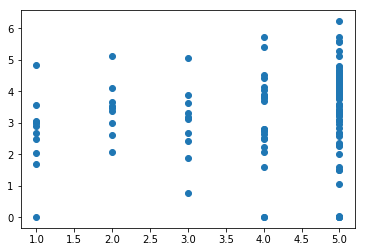

In [191]:
plt.scatter(test_y, yhat_multi)

# Memory cleanup

In [192]:
import gc
tf.keras.backend.clear_session()
gc.collect()

28473